# Training the model

In [21]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [22]:
import sys
sys.path.append("/home/paperspace/fastai/")

In [23]:
# This file contains all the main external libs we'll use
from fastai.imports import *

In [24]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [25]:
%pwd

'/home/paperspace/Nutrition_Journal'

In [26]:
PATH = "/home/paperspace/Nutrition_Journal/food_resnet/"
sz=224
arch=resnet34
bs = 64

In [27]:
label_csv = f'{PATH}labels.csv'
n = len(list(open(label_csv)))-1
val_idxs = get_cv_idxs(n)
n, len(val_idxs)

(115294, 23058)

In [28]:
!ls {PATH}

labels.csv  models  test  tmp  train


In [29]:
ls '/home/paperspace/Nutrition_Journal/Images' | wc -l

115287


In [30]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

In [31]:
data = ImageClassifierData.from_csv(PATH, 'train', f'{PATH}labels.csv', test_name = 'test',
                                   val_idxs = val_idxs, suffix = '.jpg', tfms = tfms, bs = bs)

In [32]:
fn = PATH+data.trn_ds.fnames[0]; fn

'/home/paperspace/Nutrition_Journal/food_resnet/train/jxxg0eik96ruzeacwdhw.jpg'

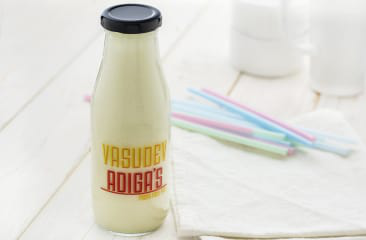

In [33]:
img = PIL.Image.open(fn); img

### Initial Model

In [14]:
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 2)

100%|██████████| 1/1 [00:00<00:00, 18.62it/s]


HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                     
    0      1.86578    1.554766   0.591725  
    1      1.691844   1.451969   0.614711                     



[array([1.45197]), 0.6147107294855078]

### Choose learning rate

In [15]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [16]:
lrf=learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 80%|███████▉  | 1149/1442 [00:16<00:04, 70.54it/s, loss=9.72]

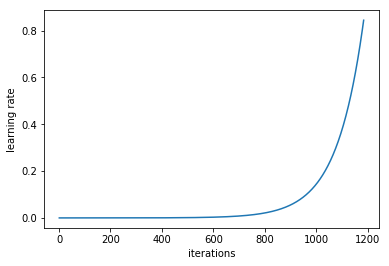

In [17]:
learn.sched.plot_lr()

 80%|███████▉  | 1149/1442 [00:30<00:07, 38.22it/s, loss=9.72]

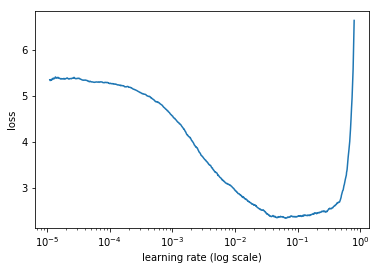

In [18]:
learn.sched.plot()

### Data Augmentation

In [19]:
def get_augs():
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    data = ImageClassifierData.from_csv(PATH, 'train', f'{PATH}labels.csv', test_name = 'test',
                                   val_idxs = val_idxs, suffix = '.jpg', tfms = tfms, bs = bs)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

In [20]:
ims = np.stack([get_augs() for i in range(6)])

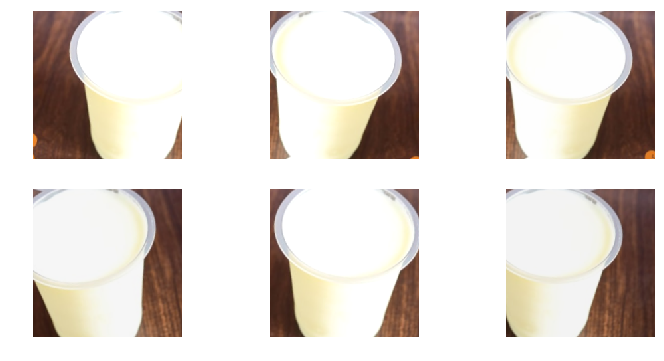

In [21]:
plots(ims, rows=2)

In [22]:
data = ImageClassifierData.from_csv(PATH, 'train', f'{PATH}labels.csv', test_name = 'test',
                                   val_idxs = val_idxs, suffix = '.jpg', tfms = tfms, bs = bs)
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [23]:
learn.fit(1e-2, 1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 46%|████▌     | 665/1442 [00:09<00:11, 68.49it/s, loss=2.11]

Exception in thread Thread-11:
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                     
    0      1.884928   1.566845   0.588039  



[array([1.56685]), 0.5880388585384168]

In [24]:
learn.precompute=False

In [25]:
learn.fit(1e-2, 3, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                     
    0      1.826042   1.481854   0.606687  
    1      1.749474   1.442687   0.614364                     
    2      1.686583   1.408348   0.623558                     



[array([1.40835]), 0.6235579842163069]

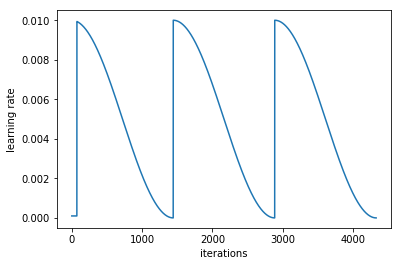

In [26]:
learn.sched.plot_lr()

In [27]:
learn.unfreeze()

In [28]:
lr=np.array([1e-4,1e-3,1e-2])

In [29]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                     
    0      1.44401    1.235594   0.664281  
    1      1.298469   1.112259   0.695377                     
    2      1.166372   1.075899   0.703921                     
    3      1.145549   1.042858   0.712811                     
    4      1.059202   0.989163   0.725909                     
    5      0.921705   0.957935   0.734929                      
    6      0.877568   0.953896   0.735406                      



[array([0.9539]), 0.7354063665745875]

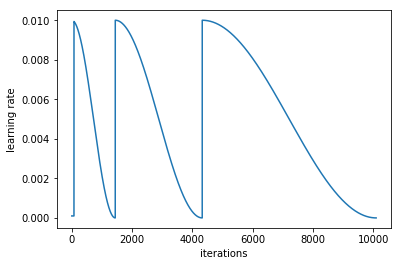

In [30]:
learn.sched.plot_lr()

In [31]:
learn.save('224_food_resnet_all')

In [34]:
learn.load('224_food_resnet_all')

In [35]:
data.classes

['Appam',
 'Beverage',
 'Biryani',
 'Biscuits',
 'Bread',
 'Breakfast',
 'Brownie',
 'Bun_Maska',
 'Burger',
 'Burritos',
 'Cake',
 'Chaat',
 'Chapati',
 'Cheesecake',
 'Chips',
 'Chocolate',
 'Coffee',
 'Continental',
 'Cookies',
 'Crepe',
 'Croissant',
 'Cupcake',
 'Dal',
 'Dessert',
 'Dips',
 'Donut',
 'Dosa',
 'Dried_Fruits',
 'Egg',
 'Frankie',
 'Fried_Rice',
 'Fried_Starters',
 'Fries',
 'Fudge',
 'Hotdog',
 'Ice_Cream',
 'Ice_cream',
 'Idli',
 'Indian_Curry',
 'Juice',
 'Kebab',
 'Keema',
 'Khichdi',
 'Kulcha',
 'Kulfi',
 'Lasagne',
 'Lassi',
 'Macarons',
 'Manchurian',
 'Meals',
 'Milkshake',
 'Momos',
 'Mousse',
 'Muffin',
 'Naan',
 'Nachos',
 'Namkeen',
 'Noodles',
 'Nuggets',
 'Omelette',
 'Paan',
 'Pancake',
 'Paratha',
 'Parotta',
 'Pasta',
 'Pastry',
 'Phulka',
 'Pickles',
 'Pizza',
 'Platter',
 'Poha',
 'Poori',
 'Popcorn',
 'Prawns',
 'Pudding',
 'Puff',
 'Pulao',
 'Quesadilla',
 'Rice',
 'Rice_Combo',
 'Roll',
 'Roti',
 'SNACKS',
 'Salad',
 'Samosa',
 'Sandwich',
 'Sav

In [36]:
data.test_ds.fnames

['test/cupcake.jpg', 'test/soups.jpeg', 'test/jilebi.jpg', 'test/biriyani.jpg']

In [37]:
log_preds,y = learn.TTA(is_test = True)
probs = np.mean(np.exp(log_preds),0)

In [38]:
probs

array([[0.0005 , 0.00002, 0.00001, 0.00003, 0.00003, 0.00003, 0.00052, 0.00004, 0.00005, 0.     , 0.86989,
        0.     , 0.00002, 0.0193 , 0.00003, 0.00316, 0.00013, 0.00013, 0.00009, 0.00009, 0.00001, 0.03835,
        0.     , 0.00651, 0.001  , 0.00006, 0.     , 0.00004, 0.00001, 0.     , 0.00008, 0.00001, 0.00004,
        0.00022, 0.     , 0.00288, 0.04044, 0.     , 0.00049, 0.00003, 0.00005, 0.00002, 0.00001, 0.     ,
        0.0001 , 0.00004, 0.00001, 0.00003, 0.     , 0.00007, 0.00017, 0.00001, 0.00047, 0.00194, 0.00003,
        0.00001, 0.00001, 0.00004, 0.00002, 0.     , 0.00003, 0.00019, 0.     , 0.     , 0.00004, 0.00199,
        0.00001, 0.00001, 0.     , 0.00002, 0.00002, 0.     , 0.00001, 0.     , 0.00053, 0.     , 0.00006,
        0.00003, 0.00539, 0.00007, 0.     , 0.     , 0.00002, 0.00019, 0.     , 0.00011, 0.     , 0.00001,
        0.00001, 0.     , 0.00008, 0.     , 0.0001 , 0.00009, 0.00008, 0.00013, 0.00004, 0.00007, 0.00008,
        0.0001 , 0.     , 0.     , 0.

In [39]:
df = pd.DataFrame(probs)
df.columns = data.classes

In [40]:
df.head()

,Appam,Beverage,Biryani,Biscuits,Bread,Breakfast,Brownie,Bun_Maska,Burger,Burritos,...,Thali,Tikka,Upma,Uttapam,Vada,Vada_Pav,Waffles,Wings,Wrap,Yogurt
0,0.000504,0.000025,1.240957e-05,3.247616e-05,0.000031,0.000033,5.182645e-04,3.880424e-05,5.472413e-05,4.740039e-06,...,1.960202e-06,0.000003,0.000020,1.952029e-07,2.313240e-07,0.000004,0.000151,0.000006,7.561803e-06,0.003010
1,0.000004,0.000047,7.941377e-07,2.524538e-07,0.000005,0.000029,4.974446e-08,8.645543e-07,9.100146e-07,3.462723e-07,...,4.105963e-07,0.000010,0.000004,5.400753e-07,7.539927e-05,0.000013,0.000002,0.000001,8.328512e-08,0.000007
2,0.000429,0.000056,8.850552e-05,5.939814e-04,0.000316,0.000514,8.585271e-05,2.207865e-04,2.121234e-02,1.554153e-04,...,3.984434e-05,0.000337,0.000234,2.313636e-05,2.056725e-04,0.000037,0.002720,0.000229,2.541474e-04,0.000077
3,0.000085,0.000046,8.853117e-01,8.700064e-06,0.000053,0.000145,7.490713e-06,2.410060e-05,1.805920e-04,1.010199e-04,...,5.196659e-04,0.000453,0.000212,2.206395e-04,2.984043e-04,0.000134,0.000027,0.000081,1.279569e-04,0.000010


In [41]:
df.insert(0, 'id', [o[5:-4] for o in data.test_ds.fnames])

In [42]:
df.head()

,id,Appam,Beverage,Biryani,Biscuits,Bread,Breakfast,Brownie,Bun_Maska,Burger,...,Thali,Tikka,Upma,Uttapam,Vada,Vada_Pav,Waffles,Wings,Wrap,Yogurt
0,cupcake,0.000504,0.000025,1.240957e-05,3.247616e-05,0.000031,0.000033,5.182645e-04,3.880424e-05,5.472413e-05,...,1.960202e-06,0.000003,0.000020,1.952029e-07,2.313240e-07,0.000004,0.000151,0.000006,7.561803e-06,0.003010
1,soups.,0.000004,0.000047,7.941377e-07,2.524538e-07,0.000005,0.000029,4.974446e-08,8.645543e-07,9.100146e-07,...,4.105963e-07,0.000010,0.000004,5.400753e-07,7.539927e-05,0.000013,0.000002,0.000001,8.328512e-08,0.000007
2,jilebi,0.000429,0.000056,8.850552e-05,5.939814e-04,0.000316,0.000514,8.585271e-05,2.207865e-04,2.121234e-02,...,3.984434e-05,0.000337,0.000234,2.313636e-05,2.056725e-04,0.000037,0.002720,0.000229,2.541474e-04,0.000077
3,biriyani,0.000085,0.000046,8.853117e-01,8.700064e-06,0.000053,0.000145,7.490713e-06,2.410060e-05,1.805920e-04,...,5.196659e-04,0.000453,0.000212,2.206395e-04,2.984043e-04,0.000134,0.000027,0.000081,1.279569e-04,0.000010


In [43]:
df.to_csv('test_results.csv')

In [4]:
%pwd

'/home/paperspace/Nutrition_Journal'

In [5]:
import sys
sys.path.append("/home/paperspace/fastai/")
from fastai.conv_learner import *

In [6]:
arch=resnet34

In [14]:
learn = ConvLearner.pretrained(arch, data)

In [15]:
learn.load('/home/paperspace/Nutrition_Journal/food_resnet/models/224_food_resnet_all')

In [16]:
data.classes

['Appam',
 'Beverage',
 'Biryani',
 'Biscuits',
 'Bread',
 'Breakfast',
 'Brownie',
 'Bun_Maska',
 'Burger',
 'Burritos',
 'Cake',
 'Chaat',
 'Chapati',
 'Cheesecake',
 'Chips',
 'Chocolate',
 'Coffee',
 'Continental',
 'Cookies',
 'Crepe',
 'Croissant',
 'Cupcake',
 'Dal',
 'Dessert',
 'Dips',
 'Donut',
 'Dosa',
 'Dried_Fruits',
 'Egg',
 'Frankie',
 'Fried_Rice',
 'Fried_Starters',
 'Fries',
 'Fudge',
 'Hotdog',
 'Ice_Cream',
 'Ice_cream',
 'Idli',
 'Indian_Curry',
 'Juice',
 'Kebab',
 'Keema',
 'Khichdi',
 'Kulcha',
 'Kulfi',
 'Lasagne',
 'Lassi',
 'Macarons',
 'Manchurian',
 'Meals',
 'Milkshake',
 'Momos',
 'Mousse',
 'Muffin',
 'Naan',
 'Nachos',
 'Namkeen',
 'Noodles',
 'Nuggets',
 'Omelette',
 'Paan',
 'Pancake',
 'Paratha',
 'Parotta',
 'Pasta',
 'Pastry',
 'Phulka',
 'Pickles',
 'Pizza',
 'Platter',
 'Poha',
 'Poori',
 'Popcorn',
 'Prawns',
 'Pudding',
 'Puff',
 'Pulao',
 'Quesadilla',
 'Rice',
 'Rice_Combo',
 'Roll',
 'Roti',
 'SNACKS',
 'Salad',
 'Samosa',
 'Sandwich',
 'Sav

In [17]:
log_preds,y = learn.TTA(is_test = True)
probs = np.mean(np.exp(log_preds),0)

In [20]:
df

,0,1,2,3,4,5,6,7,8,9,...,100,101,102,103,104,105,106,107,108,109
0,0.000608,0.000078,0.000008,1.125000e-04,0.000083,0.000076,1.404518e-03,0.000062,0.000099,1.155885e-05,...,0.000004,0.000007,0.000025,2.217183e-07,0.000001,0.000007,0.000361,0.000023,2.785023e-05,0.006827
1,0.000007,0.000088,0.000002,7.629740e-07,0.000018,0.000082,1.958345e-07,0.000003,0.000004,9.047469e-07,...,0.000001,0.000031,0.000010,1.216785e-06,0.000153,0.000054,0.000004,0.000003,3.474358e-07,0.000012
2,0.000417,0.000090,0.000162,5.679455e-04,0.000340,0.000500,1.049971e-04,0.000272,0.021848,1.455979e-04,...,0.000055,0.000408,0.000351,2.699540e-05,0.000253,0.000053,0.001463,0.000392,1.873737e-04,0.000079
3,0.000020,0.000010,0.935188,1.740097e-06,0.000008,0.000035,1.755902e-06,0.000007,0.000044,1.982409e-05,...,0.000151,0.000190,0.000051,4.091038e-05,0.000057,0.000034,0.000006,0.000026,3.115469e-05,0.000003


In [32]:
df = pd.DataFrame(probs)
df.columns = data.classes
df.insert(0, 'id', [o[5:-4] for o in data.test_ds.fnames])

In [10]:
model = learn.model()
the_model.eval() # shows the entire network architecture

AttributeError: 'collections.OrderedDict' object has no attribute 'eval'

NameError: name 'df' is not defined